<a href="https://colab.research.google.com/github/davidh1990/Laboratorio-3_-big-data/blob/main/Clustering_KMeans_revision_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Corrección**- Analisis de las zonas de peligro tomando las 4 caracteristicas de referencia y buscando los hiperparametros mas adecuados con el metodo del codo.

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
import geopandas as gpd
import plotly.graph_objects as go
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score


In [13]:
from google.colab import drive
drive.mount('/content/drive')
archivo = '/content/drive/MyDrive/UPSO/ML/Crimenes.csv'
#carga el archivo CSV
df_original = pd.read_csv(archivo)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
df_original

,Estado,Asesinatos,Asaltos,Poblacion Urbana,Violaciones
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6
5,Colorado,7.9,204,78,38.7
6,Connecticut,3.3,110,77,11.1
7,Delaware,5.9,238,72,15.8
8,Florida,15.4,335,80,31.9
9,Georgia,17.4,211,60,25.8


Analizando el dataset

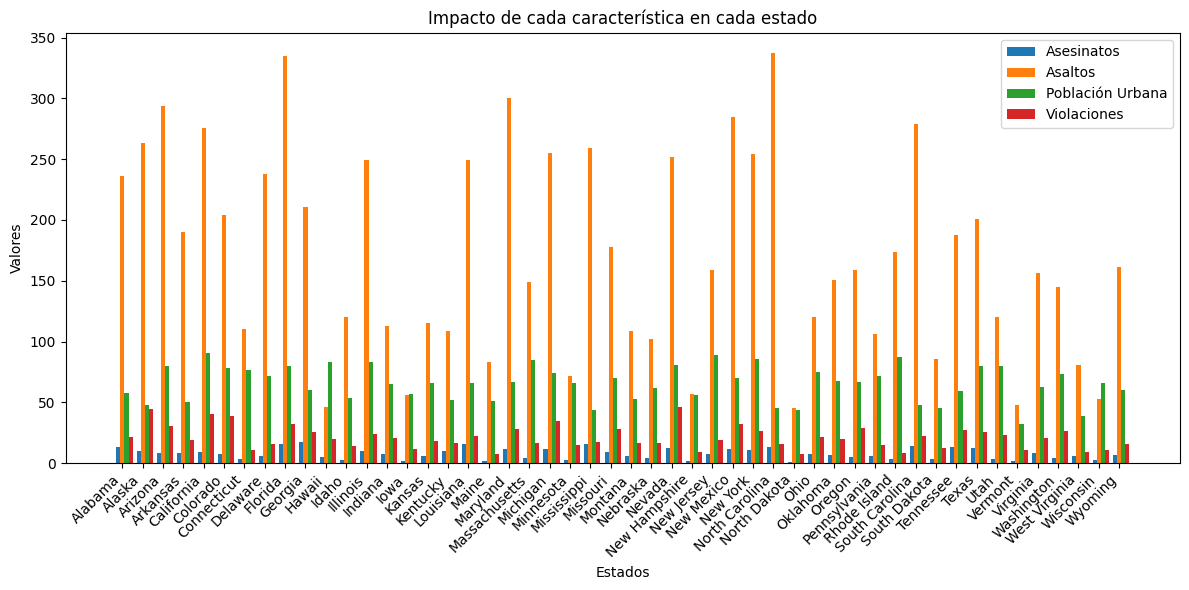

In [15]:
# Datos
estados = df_original['Estado']
asesinatos = df_original['Asesinatos']
asaltos = df_original['Asaltos']
poblacion_urbana = df_original['Poblacion Urbana']
violaciones = df_original['Violaciones']

# Creo un índice para los estados
x = np.arange(len(estados))

# Creo gráficos de barras para cada característica
width = 0.2
fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width, asesinatos, width, label='Asesinatos')
rects2 = ax.bar(x, asaltos, width, label='Asaltos')
rects3 = ax.bar(x + width, poblacion_urbana, width, label='Población Urbana')
rects4 = ax.bar(x + 2*width, violaciones, width, label='Violaciones')

# Añado etiquetas, título y leyenda
ax.set_xlabel('Estados')
ax.set_ylabel('Valores')
ax.set_title('Impacto de cada característica en cada estado')
ax.set_xticks(x)
ax.set_xticklabels(estados, rotation=45, ha='right')
ax.legend()

#Gráfico
plt.tight_layout()
plt.show()

In [16]:
import random


# Función que calcula la incidencia de la caracteristica con respecto a la población urbana (por cada 100,000 habitantes)
def graficarIncidencia (caracteristica):
  df= df_original.copy()

  colormap = plt.cm.get_cmap('nipy_spectral', 100) # usando colormap de matplotlib le asigno un gradiente de colores
  lista_colores = []
  for x in df.index:                               # aqui recorro el dataframe y le asigno diferentes colores a la variable colormap y agrego a la lista
    lista_colores.append(colormap(x+20))

  df[f'Incidencia_{caracteristica}'] = (df[caracteristica] / df['Poblacion Urbana']) * 100000
  # Calculo la incidencia total de la caracteristica respecto a la población urbana total
  total_caracteristica = df[caracteristica].sum()
  total_poblacion_urbana = df['Poblacion Urbana'].sum()
  incidencia_total = (total_caracteristica / total_poblacion_urbana) * 100000

  # Grafico la incidencia de la caracteristica por estado
  plt.figure(figsize=(12, 6))

  plt.bar(df['Estado'], df[f'Incidencia_{caracteristica}'],color= lista_colores)  # utilizo la lista de colores para las barras


  plt.axhline(y=incidencia_total, color='red', linestyle='--', label= f'Incidencia total de {caracteristica} en el total de Estado')

  plt.title(f'Incidencia de {caracteristica} por cada 100,000 habitantes por Estado')
  plt.xlabel('Estado')
  plt.ylabel(f'Incidencia de {caracteristica} por 100,000 habitantes')
  plt.xticks(rotation=90)
  plt.legend()
  plt.grid(axis='y')

  plt.show()


<ipython-input-16-01f1d94cd50c>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('nipy_spectral', 100) # usando colormap de matplotlib le asigno un gradiente de colores


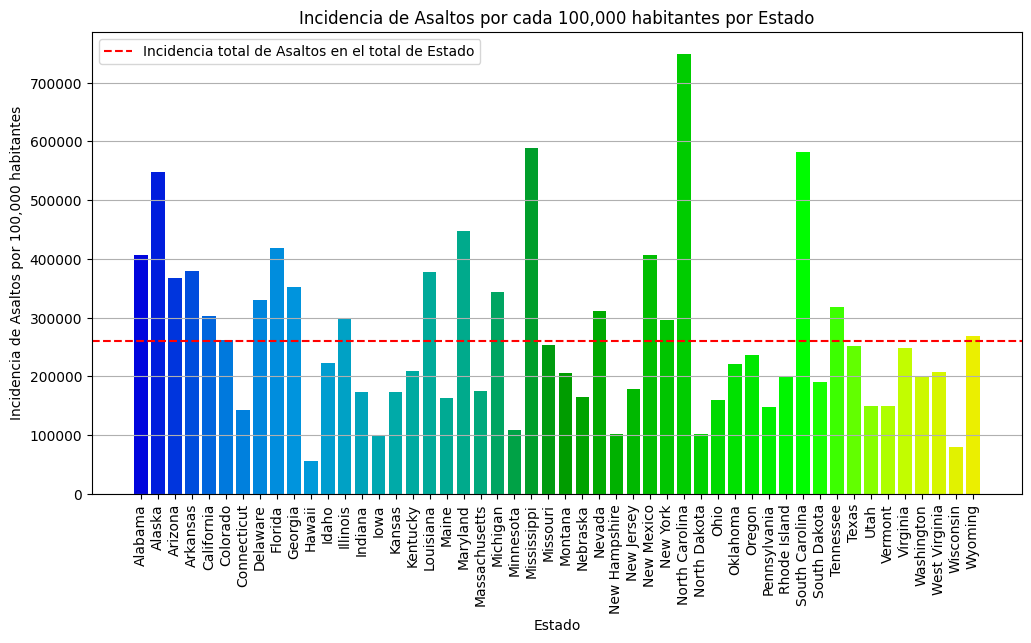

<ipython-input-16-01f1d94cd50c>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('nipy_spectral', 100) # usando colormap de matplotlib le asigno un gradiente de colores


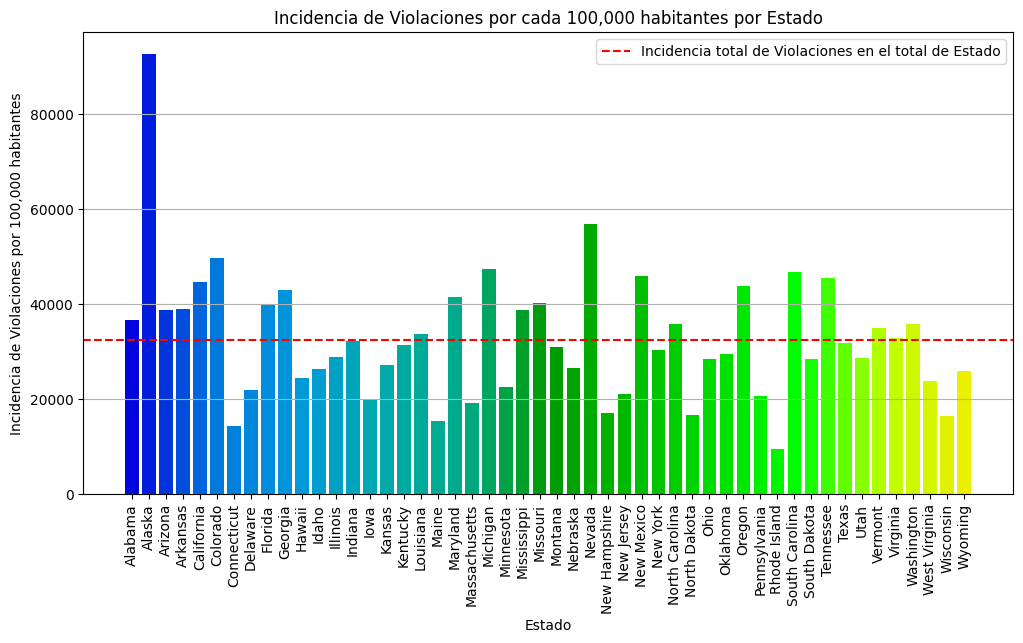

<ipython-input-16-01f1d94cd50c>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('nipy_spectral', 100) # usando colormap de matplotlib le asigno un gradiente de colores


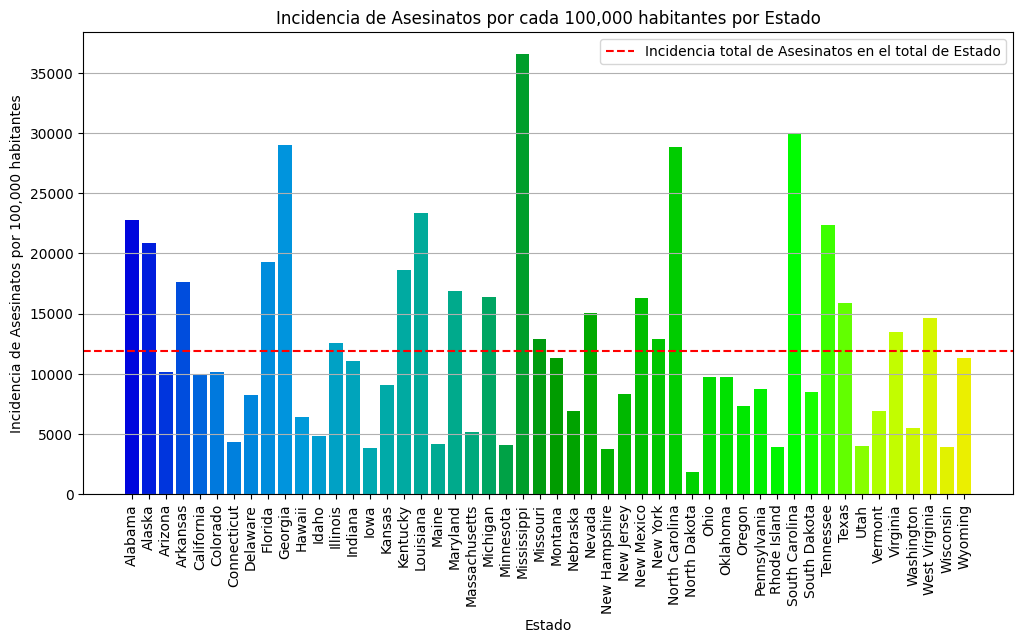

In [17]:
#llamo a la función graficarIncidencia con las caracteristicas de: Asesinatos, Asaltos, Violaciones
graficarIncidencia('Asaltos')
graficarIncidencia('Violaciones')
graficarIncidencia('Asesinatos')

Normalización de datos

In [18]:
df= df_original.copy()
# Características a normalizar
Normalizar = ['Asesinatos', 'Asaltos', 'Poblacion Urbana', 'Violaciones']
X = df[Normalizar]

#scalo
scaler = MinMaxScaler()
dfNormalizado = scaler.fit_transform(X)

# Reemplazo las columnas originales con las normalizadas en el DataFrame
df[Normalizar] = dfNormalizado


Metodo del codo

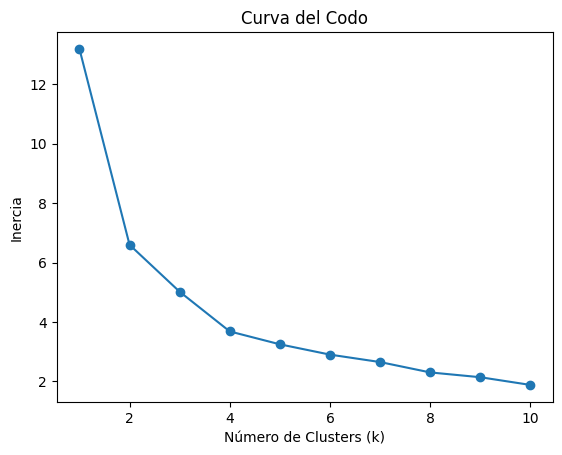

In [19]:
#Curva del CODO ver Cluster apropiado
inercias = []

X = dfNormalizado

# Pruebo con un rango de valores de k, por ejemplo, de 1 a 10
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42,n_init=10)
    kmeans.fit(X)
    inercias.append(kmeans.inertia_)

# Graficamos la curva del codo
plt.plot(range(1, 11), inercias, marker='o')
plt.title('Curva del Codo')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia')
plt.show()


Agruparemos en tres cluster: baja, media y alta peligrosidad

In [20]:
# Utilizamos 3 clusters
kmeans = KMeans(n_clusters=3, n_init=20, random_state=42)
kmeans.fit(dfNormalizado)

# Obtengo los centroides finales y las etiquetas de cluster
centroides_finales = kmeans.cluster_centers_

#Agrego predicciones en una nueva columna del df original
df['Peligrosidad'] = kmeans.fit_predict(dfNormalizado)

#Inercia de la mejor solución
inercia_mejor_solucion = kmeans.inertia_

df

,Estado,Asesinatos,Asaltos,Poblacion Urbana,Violaciones,Peligrosidad
0,Alabama,0.746988,0.654110,0.440678,0.359173,2
1,Alaska,0.554217,0.746575,0.271186,0.961240,2
2,Arizona,0.439759,0.852740,0.813559,0.612403,2
3,Arkansas,0.481928,0.496575,0.305085,0.315245,1
4,California,0.493976,0.791096,1.000000,0.860465,2
5,Colorado,0.427711,0.544521,0.779661,0.811370,2
6,Connecticut,0.150602,0.222603,0.762712,0.098191,1
7,Delaware,0.307229,0.660959,0.677966,0.219638,1
8,Florida,0.879518,0.993151,0.813559,0.635659,2
9,Georgia,1.000000,0.568493,0.474576,0.478036,2


Asignamos etiquetas a cada cluster

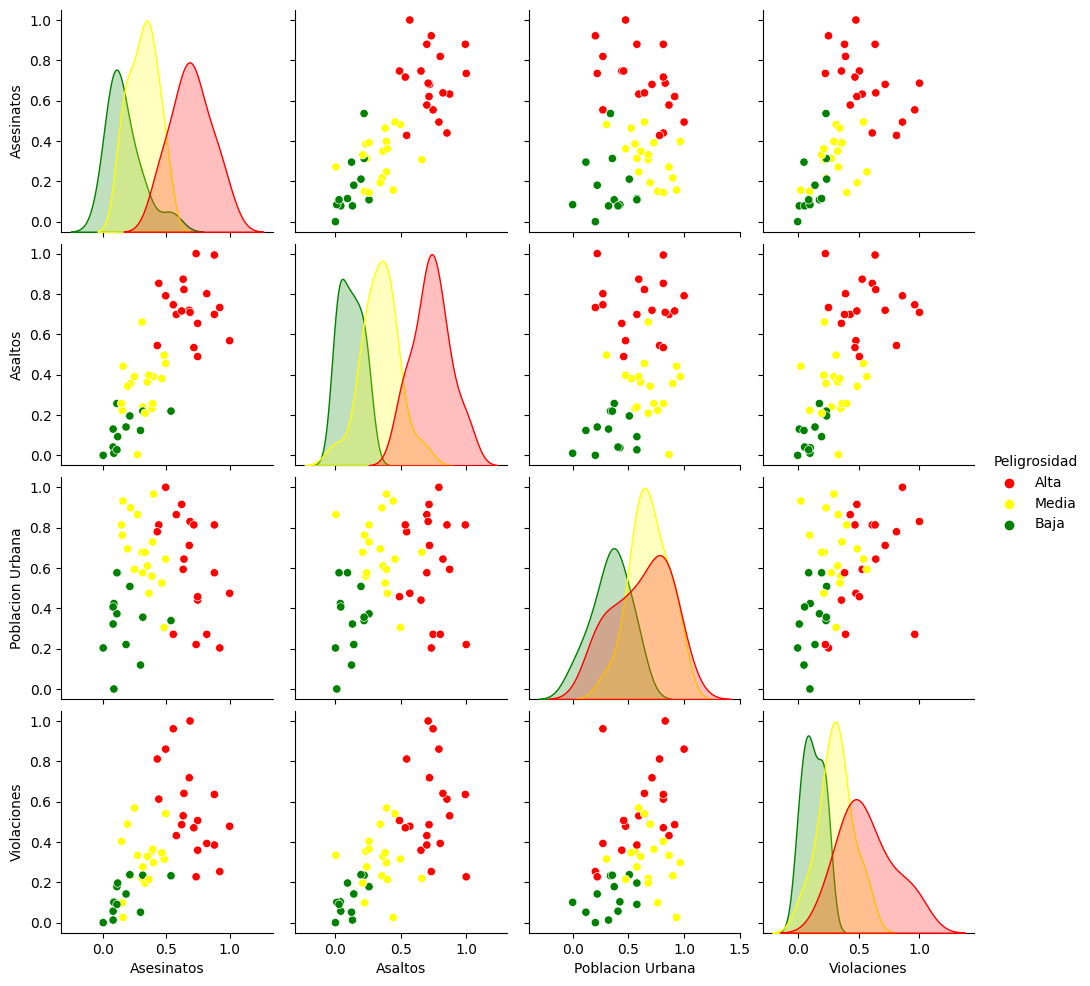

In [21]:
df['Peligrosidad'] = df['Peligrosidad'].astype(int)
# Asigno nombres a los clusters
df['Peligrosidad'] = df['Peligrosidad'].map({0: 'Baja', 1: 'Media',2:'Alta'})
# Visualizo los clusters con etiquetas de peligrosidad
sns.pairplot(df, hue='Peligrosidad', palette={'Baja': 'green', 'Alta': 'red','Media':'yellow'})
plt.show()

Estados vs Peligrosidades

In [22]:
# Estados de baja peligrosidad
zonasPeligroBajo = df[df['Peligrosidad'] == 'Baja']
print("Estados de Baja Peligrosidad:")
print(zonasPeligroBajo[['Estado', 'Peligrosidad']])

# Eestados de media peligrosidad
zonasPeligroAlto = df[df['Peligrosidad'] == 'Media']
print("\nEstados de Media Peligrosidad:")
print(zonasPeligroAlto[['Estado', 'Peligrosidad']])

# Eestados de alta peligrosidad
zonasPeligroAlto = df[df['Peligrosidad'] == 'Alta']
print("\nEstados de Alta Peligrosidad:")
print(zonasPeligroAlto[['Estado', 'Peligrosidad']])

Estados de Baja Peligrosidad:
           Estado Peligrosidad
11          Idaho         Baja
14           Iowa         Baja
16       Kentucky         Baja
18          Maine         Baja
22      Minnesota         Baja
25        Montana         Baja
26       Nebraska         Baja
28  New Hampshire         Baja
33   North Dakota         Baja
40   South Dakota         Baja
44        Vermont         Baja
47  West Virginia         Baja
48      Wisconsin         Baja

Estados de Media Peligrosidad:
           Estado Peligrosidad
3        Arkansas        Media
6     Connecticut        Media
7        Delaware        Media
10         Hawaii        Media
13        Indiana        Media
15         Kansas        Media
20  Massachusetts        Media
24       Missouri        Media
29     New Jersey        Media
34           Ohio        Media
35       Oklahoma        Media
36         Oregon        Media
37   Pennsylvania        Media
38   Rhode Island        Media
43           Utah        Media
45      

Estadistica de cada Zona de Peligrosidad

In [23]:
# Calculo estadísticas para cada cluster
cluster_stats = df.groupby('Peligrosidad').agg({
    'Asesinatos': ['mean', 'std'],
    'Asaltos': ['mean', 'std'],
    'Poblacion Urbana': ['mean', 'std'],
    'Violaciones': ['mean', 'std', 'count']
}).round(2)

# Imprimir estadísticas de cada cluster
cluster_stats

Asesinatos       Asaltos       Poblacion Urbana        \
                   mean   std    mean   std             mean   std   
Peligrosidad                                                         
Alta               0.69  0.16    0.73  0.14             0.62  0.25   
Baja               0.17  0.14    0.11  0.09             0.34  0.17   
Media              0.31  0.11    0.34  0.14             0.68  0.17   

             Violaciones              
                    mean   std count  
Peligrosidad                          
Alta                0.57  0.22    19  
Baja                0.13  0.08    13  
Media               0.31  0.14    18

Valores de Evaluación

In [24]:
X = dfNormalizado
# Inercia
inertia = kmeans.inertia_
print(f'Inercia: {inertia}')

# Coeficiente de silueta
silhouette_avg = silhouette_score(X, df['Peligrosidad'])
print(f'Coeficiente de Silueta: {silhouette_avg}')

Inercia: 5.010878493006417
Coeficiente de Silueta: 0.3187755079997931


Nota: Un valor bajo de inercia es deseable, ya que significa que los puntos dentro de los clusters están más cerca entre sí.
Un coeficiente de silueta cercano a 1 es preferible. Indicando una buena cohesión dentro de los clusters y una buena separación entre los clusters.

Visualizacion en 2d de las caracteristicas (Asesinatos y Asaltos)

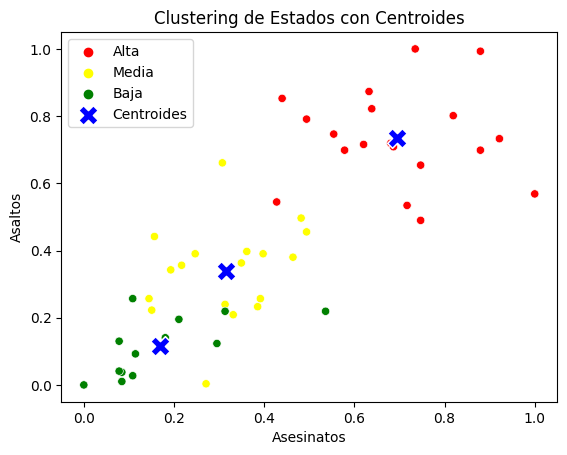

In [25]:
# Gráfico de dispersión de los datos
sns.scatterplot(x='Asesinatos', y='Asaltos', hue='Peligrosidad', data=df, palette=['red', 'yellow','green'])

# Marco los centroides
centroids = kmeans.cluster_centers_
sns.scatterplot(x=centroids[:, 0], y=centroids[:, 1], marker='X', s=200, color='blue', label='Centroides')

plt.title('Clustering de Estados con Centroides')
plt.legend()
plt.show()

Zonas Peligrosas en 3D

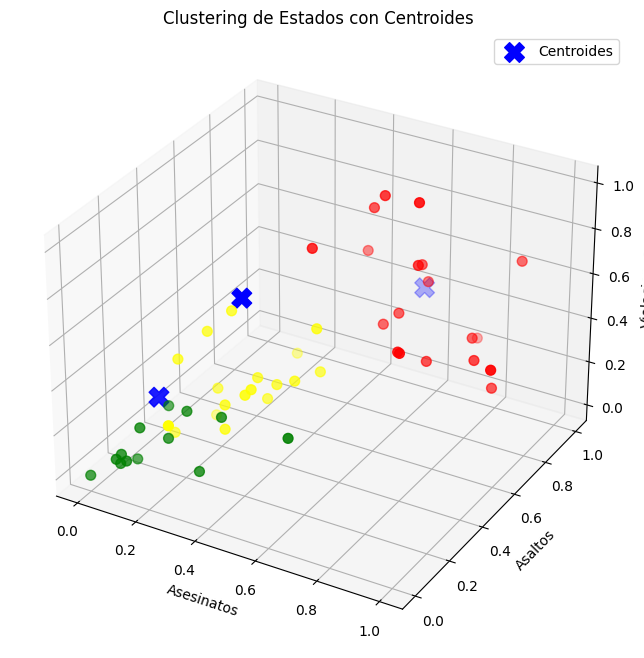

In [26]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df['Asesinatos'], df['Asaltos'], df['Violaciones'], c=df['Peligrosidad'].map({'Baja': 'green', 'Alta': 'red','Media': 'yellow'}), s=50)
ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], marker='X', s=200, color='blue', label='Centroides')

ax.set_xlabel('Asesinatos')
ax.set_ylabel('Asaltos')
ax.set_zlabel('Violaciones')
ax.set_title('Clustering de Estados con Centroides')

plt.legend()
plt.show()


Mejor representación (interactiva)

In [27]:
# Inicio gráfico tridimensional interactivo
fig = px.scatter_3d(df, x='Asesinatos', y='Asaltos', z='Violaciones', color='Peligrosidad',
                    symbol='Peligrosidad', opacity=0.7, size_max=10)

# Marco los centroides
centroid_df = pd.DataFrame(centroids[:, :3], columns=['Asesinatos', 'Asaltos', 'Violaciones'])
fig.add_scatter3d(x=centroid_df['Asesinatos'], y=centroid_df['Asaltos'], z=centroid_df['Violaciones'],
                  mode='markers', marker=dict(size=10, color='grey', line=dict(color='black', width=2)),
                  name='Centroides')

fig.show()

Representacion de los estados en un mapa de Estados Unidos,segun su peligrosidad.

<ipython-input-28-d03566c8dd74>:18: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




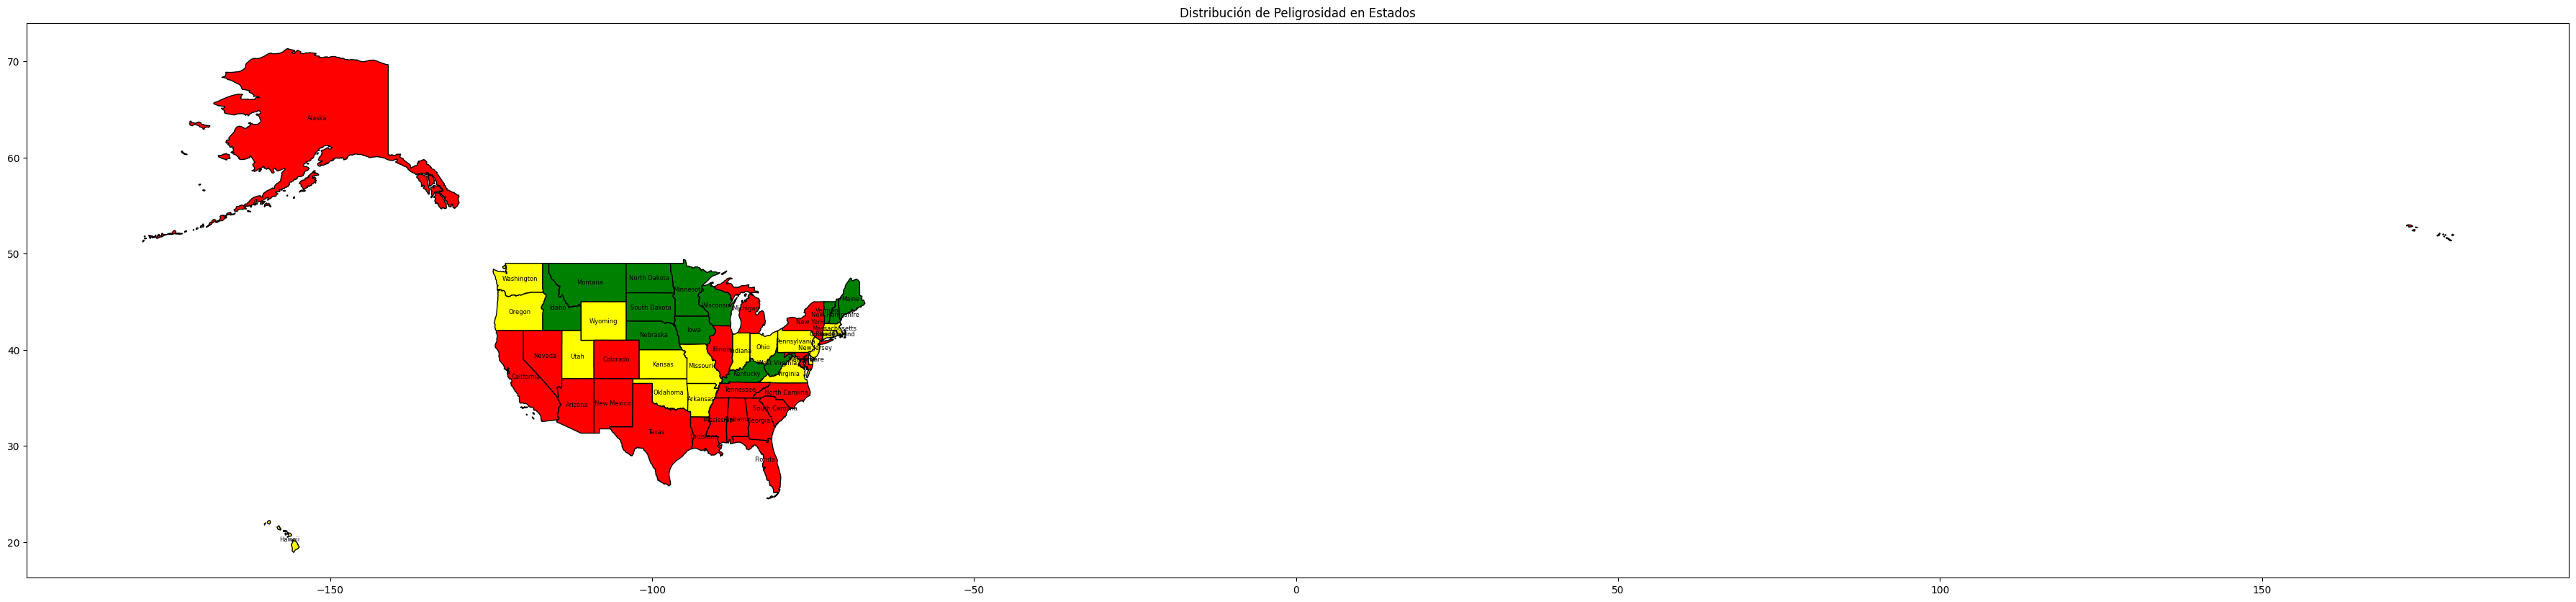

In [28]:
# URL de descarga de límites estatales de Estados Unidos desde Natural Earth
url = "https://www2.census.gov/geo/tiger/GENZ2020/shp/cb_2020_us_state_20m.zip"

# Cargo el GeoDataFrame desde el archivo
gdf = gpd.read_file(url)

# Emparejo nombres de estados
gdf_merged = gdf.merge(df, how='inner', left_on='NAME', right_on='Estado')

fig, ax = plt.subplots(figsize=(60, 10))

# Plot de estados con baja, media y alta peligrosidad
gdf_merged[gdf_merged['Peligrosidad'] == 'Baja'].plot(ax=ax, color='green', edgecolor='black', label='Baja Peligrosidad')
gdf_merged[gdf_merged['Peligrosidad'] == 'Media'].plot(ax=ax, color='yellow', edgecolor='black', label='Baja Peligrosidad')
gdf_merged[gdf_merged['Peligrosidad'] == 'Alta'].plot(ax=ax, color='red', edgecolor='black', label='Alta Peligrosidad')

# Etiquetado de cada estado
for x, y, label in zip(gdf_merged.geometry.centroid.x, gdf_merged.geometry.centroid.y, gdf_merged['Estado']):
    ax.text(x, y, label, fontsize=6, ha='center', va='center')

ax.set_title('Distribución de Peligrosidad en Estados')

plt.show()